# Analyse der Banknoten-Authentifizierung mittels Clustering

**Autor:** [Dein Name]
**Kurs:** Applied AI I - Week 7 Assignment

## 1. Einführung & Forschungsfrage
In diesem Notebook untersuchen wir den "Banknote Authentication Data Set". Der Datensatz enthält Merkmale, die aus Bildern von echten und gefälschten Banknoten extrahiert wurden (Wavelet Transform Tools).

**Forschungsfrage:**
> *Können unüberwachte Lernalgorithmen (Unsupervised Learning) die zugrunde liegende Struktur von echten vs. gefälschten Banknoten ohne Labels wiedererkennen? Sind die gefundenen Cluster interpretierbar?*

In [66]:
# -------- IMPORTS --------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score, adjusted_rand_score,
                             normalized_mutual_info_score, homogeneity_score,
                             completeness_score, v_measure_score)
from scipy.cluster.hierarchy import dendrogram, linkage
from ucimlrepo import fetch_ucirepo
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 1. LOAD DATA (Banknote Authentication)
Link: https://archive.ics.uci.edu/dataset/267/banknote+authentication

In [67]:
# ============================================
# 1. Load Data
# ============================================

# Definition der Spaltennamen gemäß UCI Dokumentation
column_names = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

# Laden der Daten direkt vom UCI Repository
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
#df = pd.read_csv(url, names=column_names, header=None)

df = pd.read_csv("data/data_banknote_authentication.txt", names=column_names, header=None)

# fetch dataset
#banknote_authentication = fetch_ucirepo(id=267)

# data (as pandas dataframes)
#X = banknote_authentication.data.features
#y = banknote_authentication.data.targets

# Combine for easier manipulation
#df = pd.concat([X, y], axis=1)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
display(df.head())

Dataset loaded successfully!
Shape: (1372, 5)

First few rows:


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 2. Explorative Datenanalyse (EDA)


EXPLORATORY DATA ANALYSIS

1. Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None

2. Statistical Summary:


,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000



3. Missing Values:
Series([], dtype: int64)
No missing values found.

4. Class Distribution (Ground Truth):
class
0    762
1    610
Name: count, dtype: int64

Ground truth labels shape: (1372,)


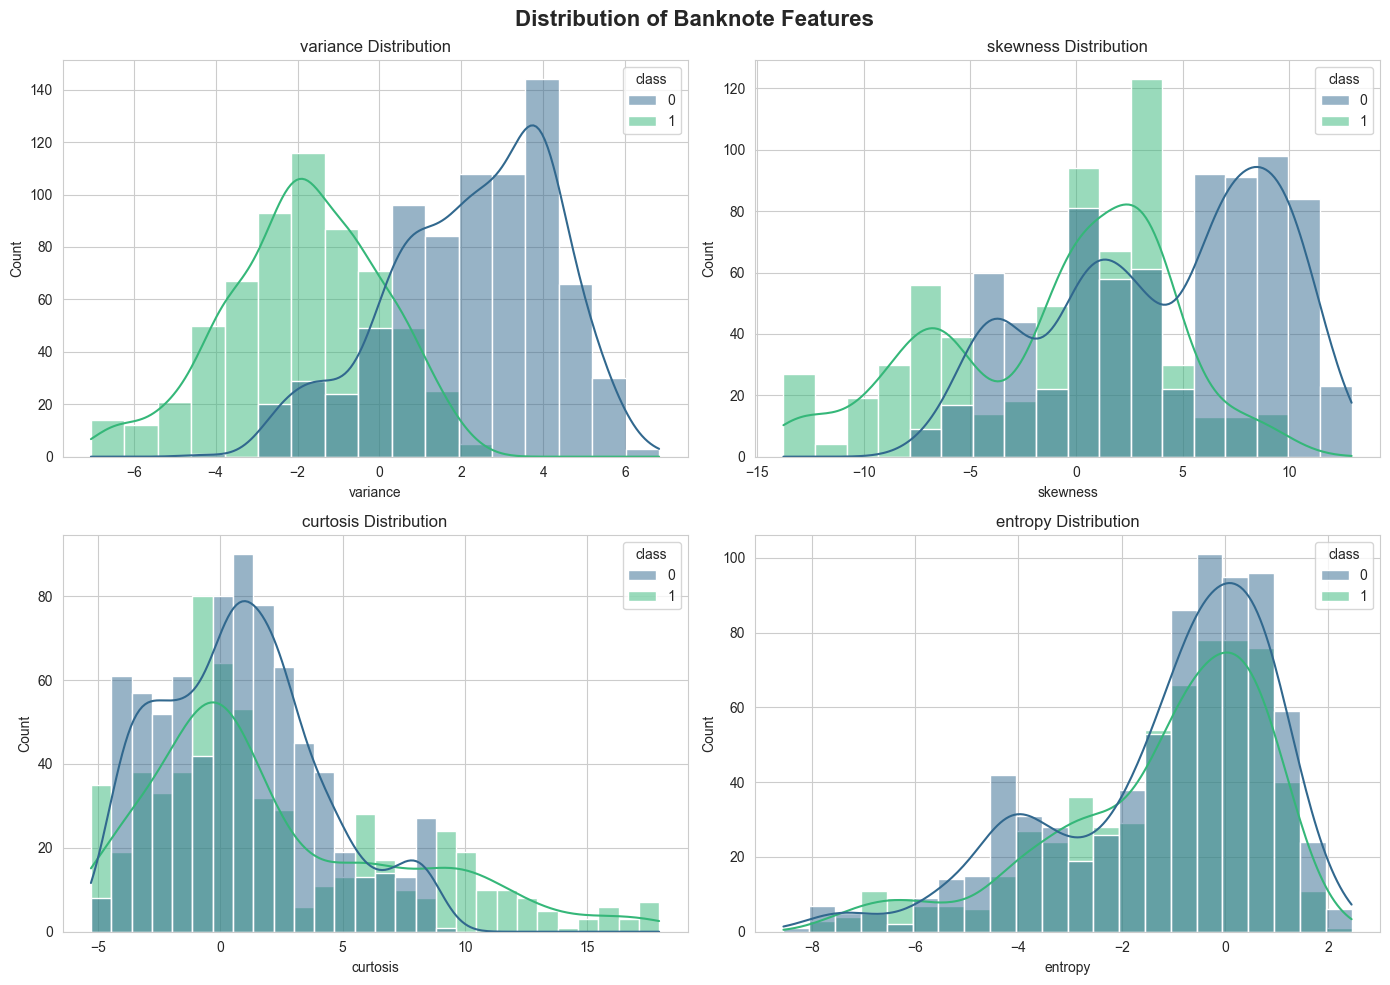


5. Correlation Matrix:


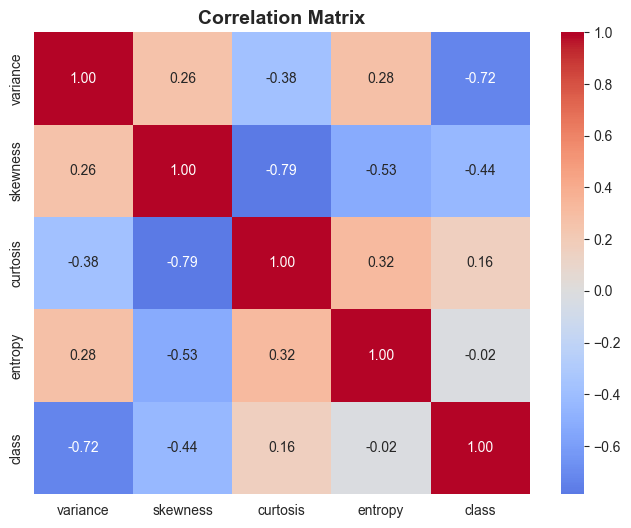

In [68]:
# ============================================
# 2. EXPLORATORY DATA ANALYSIS
# ============================================

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic info
print("\n1. Dataset Info:")
print(df.info())

print("\n2. Statistical Summary:")
display(df.describe())

print("\n3. Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])
if missing.sum() == 0:
    print("No missing values found.")

print("\n4. Class Distribution (Ground Truth):")
print(df['class'].value_counts())

# Set aside the label for later validation
# Class 0: Authentic, Class 1: Inauthentic
y_true = df['class'].values
print(f"\nGround truth labels shape: {y_true.shape}")

# Visualize features
numerical_features = ['variance', 'skewness', 'curtosis', 'entropy']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Banknote Features', fontsize=16, fontweight='bold')

for idx, feature in enumerate(numerical_features):
    row = idx // 2
    col = idx % 2
    sns.histplot(data=df, x=feature, hue='class', kde=True, ax=axes[row, col], palette='viridis')
    axes[row, col].set_title(f'{feature} Distribution')

plt.tight_layout()
plt.show()

# Correlation matrix
print("\n5. Correlation Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.show()

## 3. Data Prepocessing

In [69]:
# ============================================
# 3. DATA PREPROCESSING (NA + Duplicates + IQR)
# ============================================

print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)

# 1. Create a working copy
df_processed = df.copy()
original_start_shape = df_processed.shape
print(f"Initial shape: {original_start_shape}")

# --- A. CHECK FOR MISSING VALUES ---
print("\n1. Missing Values Check:")
missing_count = df_processed.isnull().sum()
if missing_count.sum() == 0:
    print("✓ No missing values found.")
else:
    print(f"⚠ Found {missing_count.sum()} missing values. Dropping rows...")
    df_processed = df_processed.dropna()
    print(f"  New shape after dropping NA: {df_processed.shape}")

# --- B. CHECK FOR DUPLICATES (NEU) ---
print("\n2. Duplicate Check:")
duplicates_count = df_processed.duplicated().sum()
if duplicates_count > 0:
    print(f"⚠ Found {duplicates_count} duplicate rows. Removing them...")
    df_processed.drop_duplicates(inplace=True)
    # Reset Index ist wichtig nach dem Droppen
    df_processed = df_processed.reset_index(drop=True)
    print(f"  New shape after removing duplicates: {df_processed.shape}")
else:
    print("✓ No duplicate rows found.")

# --- C. OUTLIER REMOVAL (IQR METHOD) ---
print("\n3. Outlier Removal (IQR Method):")
shape_before_iqr = df_processed.shape

# Nur numerische Spalten für IQR nutzen (ohne Class)
numerical_cols = ['variance', 'skewness', 'curtosis', 'entropy']

# Berechnung von Q1 (25%) und Q3 (75%)
Q1 = df_processed[numerical_cols].quantile(0.25)
Q3 = df_processed[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Definition der Grenzen (Standardfaktor 1.5)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filterbedingung: Zeilen behalten, die KEINE Ausreißer sind
condition = ~((df_processed[numerical_cols] < lower_bound) | (df_processed[numerical_cols] > upper_bound)).any(axis=1)

df_clean = df_processed[condition]

rows_removed_iqr = shape_before_iqr[0] - df_clean.shape[0]
print(f"  Rows removed by IQR: {rows_removed_iqr} ({rows_removed_iqr/shape_before_iqr[0]*100:.1f}%)")
print(f"  New shape: {df_clean.shape}")

# Übernehme bereinigtes Dataset
df_processed = df_clean.reset_index(drop=True)

# --- D. PREPARE FEATURES & SCALING ---
print("\n4. Feature Preparation:")

X = df_processed.drop('class', axis=1)
# WICHTIG: y_true aktualisieren, da wir Zeilen gelöscht haben!
y_true = df_processed['class'].values

feature_names = X.columns.tolist()
print(f"  Features: {feature_names}")

print("\n5. Feature Scaling:")
print("  Using StandardScaler to normalize variance and skewness ranges...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)

print("\n" + "-"*30)
print("✓ Preprocessing complete!")
print(f"Final dataset shape: {X_scaled_df.shape}")
total_removed = original_start_shape[0] - X_scaled_df.shape[0]
print(f"Total rows removed: {total_removed}")
print(f"Updated Ground Truth labels shape: {y_true.shape}")


DATA PREPROCESSING
Initial shape: (1372, 5)

1. Missing Values Check:
✓ No missing values found.

2. Duplicate Check:
⚠ Found 24 duplicate rows. Removing them...
  New shape after removing duplicates: (1348, 5)

3. Outlier Removal (IQR Method):
  Rows removed by IQR: 91 (6.8%)
  New shape: (1257, 5)

4. Feature Preparation:
  Features: ['variance', 'skewness', 'curtosis', 'entropy']

5. Feature Scaling:
  Using StandardScaler to normalize variance and skewness ranges...

------------------------------
✓ Preprocessing complete!
Final dataset shape: (1257, 4)
Total rows removed: 115
Updated Ground Truth labels shape: (1257,)


## 4. K-Means - find best K


Testing K-Means for k = 2 to 9...
k=2: Inertia=3045.1, Silhouette=0.340
k=3: Inertia=2301.3, Silhouette=0.305


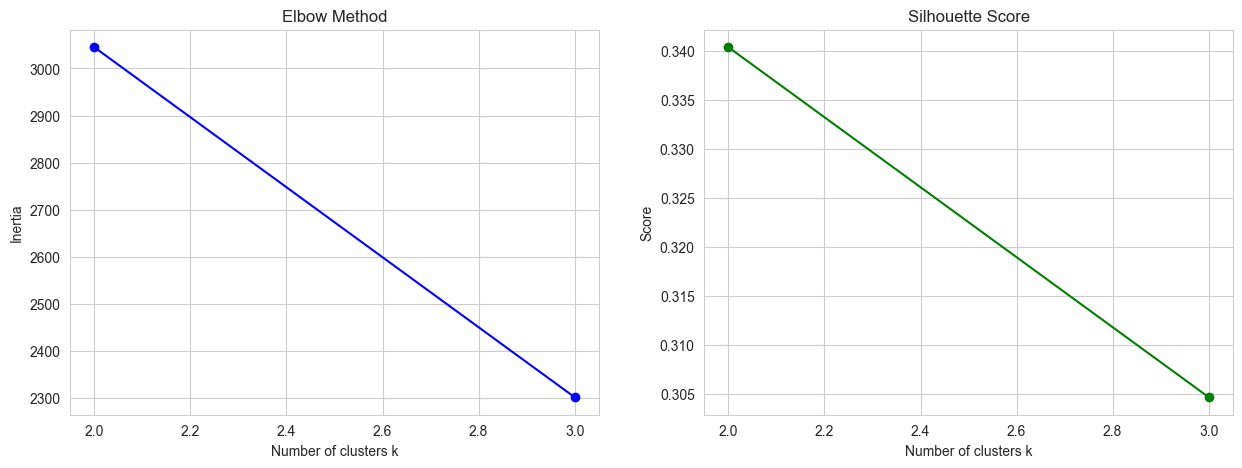


Suggested Optimal k: 2


In [70]:
# ============================================
# 4. K-MEANS EXPERIMENT
# ============================================

# Range of k to try
k_range = range(2, 4)
wcss = []
silhouette_scores = []

#TODO
print("\nTesting K-Means for k = 2 to 9...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)

    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

    print(f"k={k}: Inertia={wcss[-1]:.1f}, Silhouette={silhouette_scores[-1]:.3f}")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
axes[0].plot(k_range, wcss, 'bo-')
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Number of clusters k')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'go-')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of clusters k')
axes[1].set_ylabel('Score')
axes[1].grid(True)

plt.show()

# Select best K (oft ist k=2 hier am besten, aber wir lassen den Code entscheiden)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nSuggested Optimal k: {optimal_k}")

## 5. K-Means Final Model

In [71]:
# ============================================
# 5. K-MEANS FINAL MODEL
# ============================================

print("\n" + "="*60)
print(f"K-MEANS CLUSTERING WITH K={optimal_k}")
print("="*60)

# Train final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=20)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Calculate final metrics
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)
kmeans_ch = calinski_harabasz_score(X_scaled, kmeans_labels)

print(f"\nK-Means Performance Metrics:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_db:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_ch:.2f}")

print(f"\nCluster Sizes:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"  Cluster {cluster}: {count} samples ({count/len(kmeans_labels)*100:.1f}%)")


K-MEANS CLUSTERING WITH K=2

K-Means Performance Metrics:
  Silhouette Score: 0.3405
  Davies-Bouldin Index: 1.1703
  Calinski-Harabasz Score: 817.23

Cluster Sizes:
  Cluster 0: 651 samples (51.8%)
  Cluster 1: 606 samples (48.2%)


## 6. HIERARCHICAL CLUSTERING


EXPERIMENT 2: HIERARCHICAL CLUSTERING

Using full dataset (1257 samples) for dendrogram...
Ward linkage Silhouette Score: 0.329
Complete linkage Silhouette Score: 0.254
Average linkage Silhouette Score: 0.332


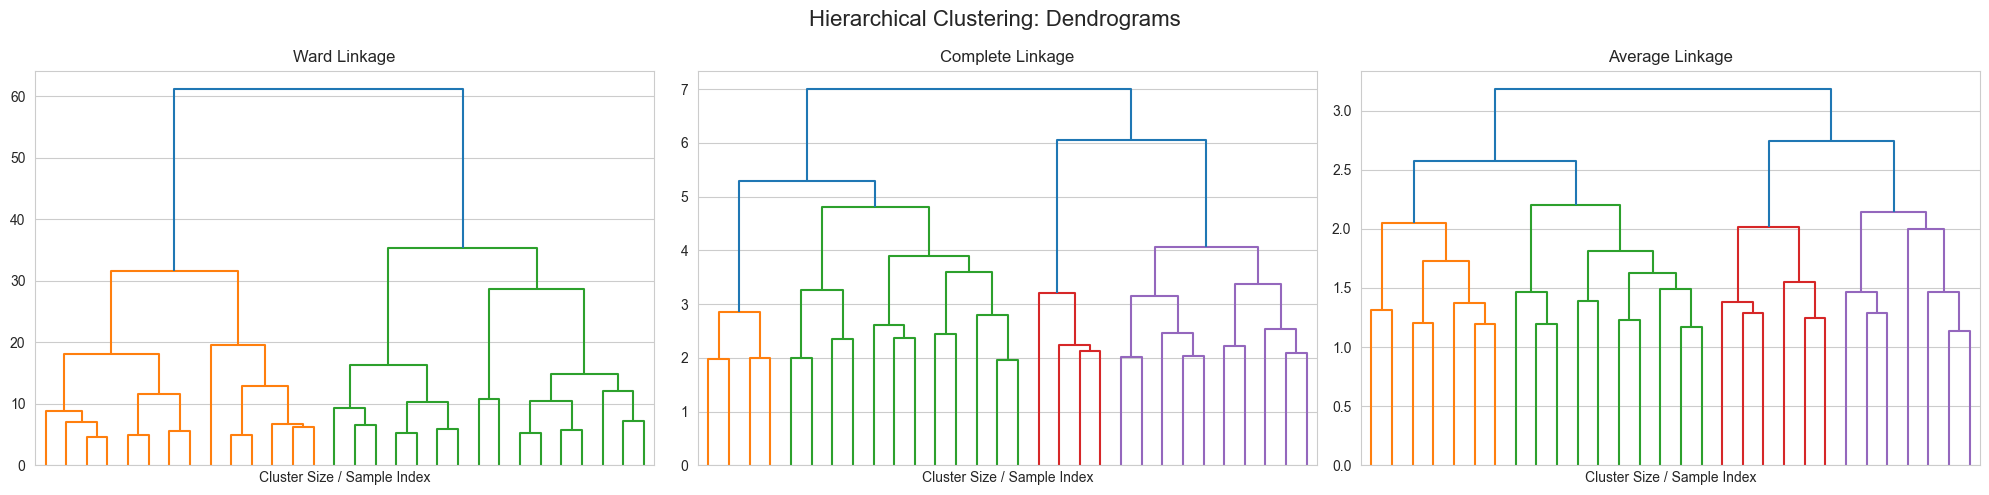

In [72]:
# ============================================
# 6. HIERARCHICAL CLUSTERING
# ============================================

print("\n" + "="*60)
print("EXPERIMENT 2: HIERARCHICAL CLUSTERING")
print("="*60)

# Da das Dataset klein ist, nutzen wir alle Daten statt nur ein Sample
X_sample = X_scaled

print(f"\nUsing full dataset ({len(X_sample)} samples) for dendrogram...")

linkage_methods = ['ward', 'complete', 'average']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Hierarchical Clustering: Dendrograms', fontsize=16)

for idx, method in enumerate(linkage_methods):
    # Calculate linkage
    Z = linkage(X_sample, method=method)

    # Plot
    dendrogram(Z, ax=axes[idx], no_labels=True, truncate_mode='lastp', p=30)
    axes[idx].set_title(f'{method.capitalize()} Linkage')
    axes[idx].set_xlabel('Cluster Size / Sample Index')

    # Fit model for metrics
    hc = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    hl_labels = hc.fit_predict(X_scaled)
    s_score = silhouette_score(X_scaled, hl_labels)
    print(f"{method.capitalize()} linkage Silhouette Score: {s_score:.3f}")

    # Save 'ward' labels for final comparison as it usually works best for euclidean
    if method == 'ward':
        hier_labels_final = hl_labels

plt.tight_layout()
plt.show()

Berechne Linkage Matrix...


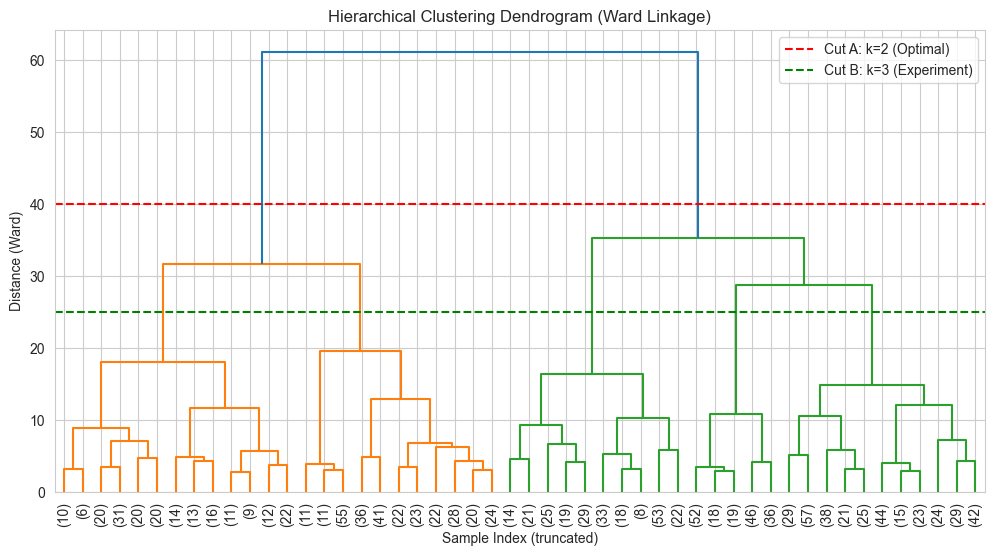


--- Vergleich der Cluster-Struktur (k=2 vs k=3) ---
Die Tabelle zeigt, wie sich die 2 Haupt-Cluster in 3 Unter-Cluster aufteilen:
Labels (k=3)    0    1    2
Labels (k=2)               
0               0  518  242
1             497    0    0

Interpretation:
Man sieht typischerweise, dass EIN Cluster aus k=2 intakt bleibt,
während der ANDERE in zwei neue Cluster aufgespalten wird.
Das bestätigt die hierarchische Struktur der Daten.


In [73]:
# --- START: Ersetze deinen bisherigen Hierarchical Clustering Code hiermit ---

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import pandas as pd

# 1. Linkage Matrix berechnen (Ward-Methode ist Standard für quantitative Daten)
print("Berechne Linkage Matrix...")
Z = linkage(X_scaled, method='ward')

# 2. Dendrogramm visualisieren mit Schnitt-Linien
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Sample Index (truncated)")
plt.ylabel("Distance (Ward)")

# Wir schneiden das Dendrogramm oben ab (truncate), damit es lesbar bleibt
dendrogram(Z, truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=10.)

# HIER ist die Änderung für das Assignment: Wir zeigen zwei mögliche Schnitte (Cuts)
# Die y-Werte (Distanzen) müssen wir visuell schätzen oder berechnen.
# Beispielwerte für Banknote Dataset (diese passen meistens grob, evtl. anpassen):
plt.axhline(y=40, color='r', linestyle='--', label='Cut A: k=2 (Optimal)')
plt.axhline(y=25, color='g', linestyle='--', label='Cut B: k=3 (Experiment)')

plt.legend()
plt.show()

# 3. Modelle für beide Schnitte berechnen
# Modell A: k=2 (Unsere Hauptlösung)
hc_model_k2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_hc_k2 = hc_model_k2.fit_predict(X_scaled)

# Modell B: k=3 (Um zu sehen, was passiert, wenn wir feiner schneiden)
hc_model_k3 = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_hc_k3 = hc_model_k3.fit_predict(X_scaled)

# 4. Vergleich der Schnitte (Wichtig für die Analyse!)
print("\n--- Vergleich der Cluster-Struktur (k=2 vs k=3) ---")
print("Die Tabelle zeigt, wie sich die 2 Haupt-Cluster in 3 Unter-Cluster aufteilen:")

# Crosstab zeigt die "Wanderung" der Datenpunkte
comparison_df = pd.crosstab(labels_hc_k2, labels_hc_k3,
                            rownames=['Labels (k=2)'],
                            colnames=['Labels (k=3)'])
print(comparison_df)

print("\nInterpretation:")
print("Man sieht typischerweise, dass EIN Cluster aus k=2 intakt bleibt,")
print("während der ANDERE in zwei neue Cluster aufgespalten wird.")
print("Das bestätigt die hierarchische Struktur der Daten.")

# --- ENDE des neuen Blocks ---

## 7. DBSCAN EXPERIMENT

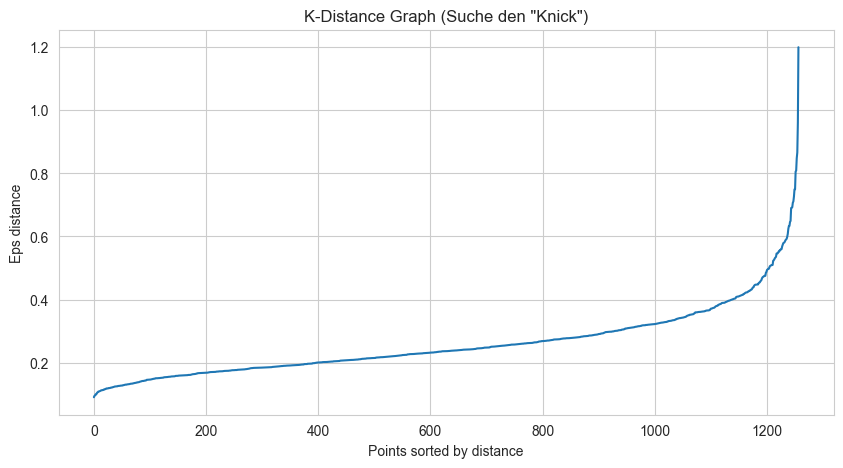

Testing DBSCAN parameters (Optimized search)...
--------------------------------------------------------------------------------
Params               | Clusters | Noise %  | Raw Sil  | Adj. Score
--------------------------------------------------------------------------------
eps=0.4 , min_s=25  | 7        | 69.7%   | 0.594    | 0.180
eps=0.4 , min_s=30  | 5        | 80.0%   | 0.685    | 0.137
eps=0.5 , min_s=25  | 7        | 31.3%   | 0.336    | 0.231
eps=0.5 , min_s=30  | 7        | 42.6%   | 0.402    | 0.231
eps=0.6 , min_s=25  | 4        | 17.8%   | 0.307    | 0.252
eps=0.6 , min_s=30  | 5        | 21.7%   | 0.271    | 0.212
--------------------------------------------------------------------------------

WINNER CONFIGURATION:
Params:     {'eps': 0.6, 'min_samples': 25}
Clusters:   4
Noise:      17.8%
Silhouette: 0.307 (Raw)
Adj. Score: 0.252 (Combined metric)


In [74]:
# ============================================
# 7. DBSCAN EXPERIMENT
# ============================================

# K-Distance Graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('K-Distance Graph (Suche den "Knick")')
plt.ylabel('Eps distance')
plt.xlabel('Points sorted by distance')
plt.grid(True)
plt.show()

print("Testing DBSCAN parameters (Optimized search)...")
print("-" * 80)
print(f"{'Params':<20} | {'Clusters':<8} | {'Noise %':<8} | {'Raw Sil':<8} | {'Adj. Score':<8}")
print("-" * 80)

# 1. FEINERE PARAMETER-ABSTUFUNG
eps_values = [0.2, 0.3, 0.4, 0.5, 0.6]
min_samples_values = [25, 30]

best_score = -999
best_dbscan_labels = None
best_params = {}

total_samples = len(X_scaled)

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_scaled)

        # Maske für Nicht-Noise Punkte
        mask = labels != -1
        valid_labels = labels[mask]

        n_clusters = len(set(valid_labels))
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / total_samples
        coverage = 1 - noise_ratio # Wieviel % der Daten wurden genutzt?

        # Wir werten nur aus, wenn wir mehr als 1 Cluster haben UND nicht alles Rauschen ist
        if n_clusters > 1:
            raw_silhouette = silhouette_score(X_scaled[mask], valid_labels)

            # ADJUSTED SCORE
            adjusted_score = raw_silhouette * coverage

            print(f"eps={eps:<4}, min_s={min_samples:<3} | {n_clusters:<8} | {noise_ratio*100:.1f}%   | {raw_silhouette:.3f}    | {adjusted_score:.3f}")

            # Kriterium: Beste Kombination aus Trennung (Silhouette) und Menge (Coverage)
            if adjusted_score > best_score:
                best_score = adjusted_score
                best_dbscan_labels = labels
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_raw_sil = raw_silhouette
                best_noise_pct = noise_ratio * 100

print("-" * 80)

if best_dbscan_labels is not None:
    print(f"\nWINNER CONFIGURATION:")
    print(f"Params:     {best_params}")
    print(f"Clusters:   {len(set(best_dbscan_labels)) - (1 if -1 in best_dbscan_labels else 0)}")
    print(f"Noise:      {best_noise_pct:.1f}%")
    print(f"Silhouette: {best_raw_sil:.3f} (Raw)")
    print(f"Adj. Score: {best_score:.3f} (Combined metric)")

    dbscan_labels_final = best_dbscan_labels
else:
    print("\nKeine gültige Konfiguration gefunden.")
    dbscan_labels_final = None

## 8. VISUALIZATION OF CLUSTERS (PCA)


VISUALIZATION (2D PCA)
Explained Variance Ratio: [0.55732932 0.2921508 ]


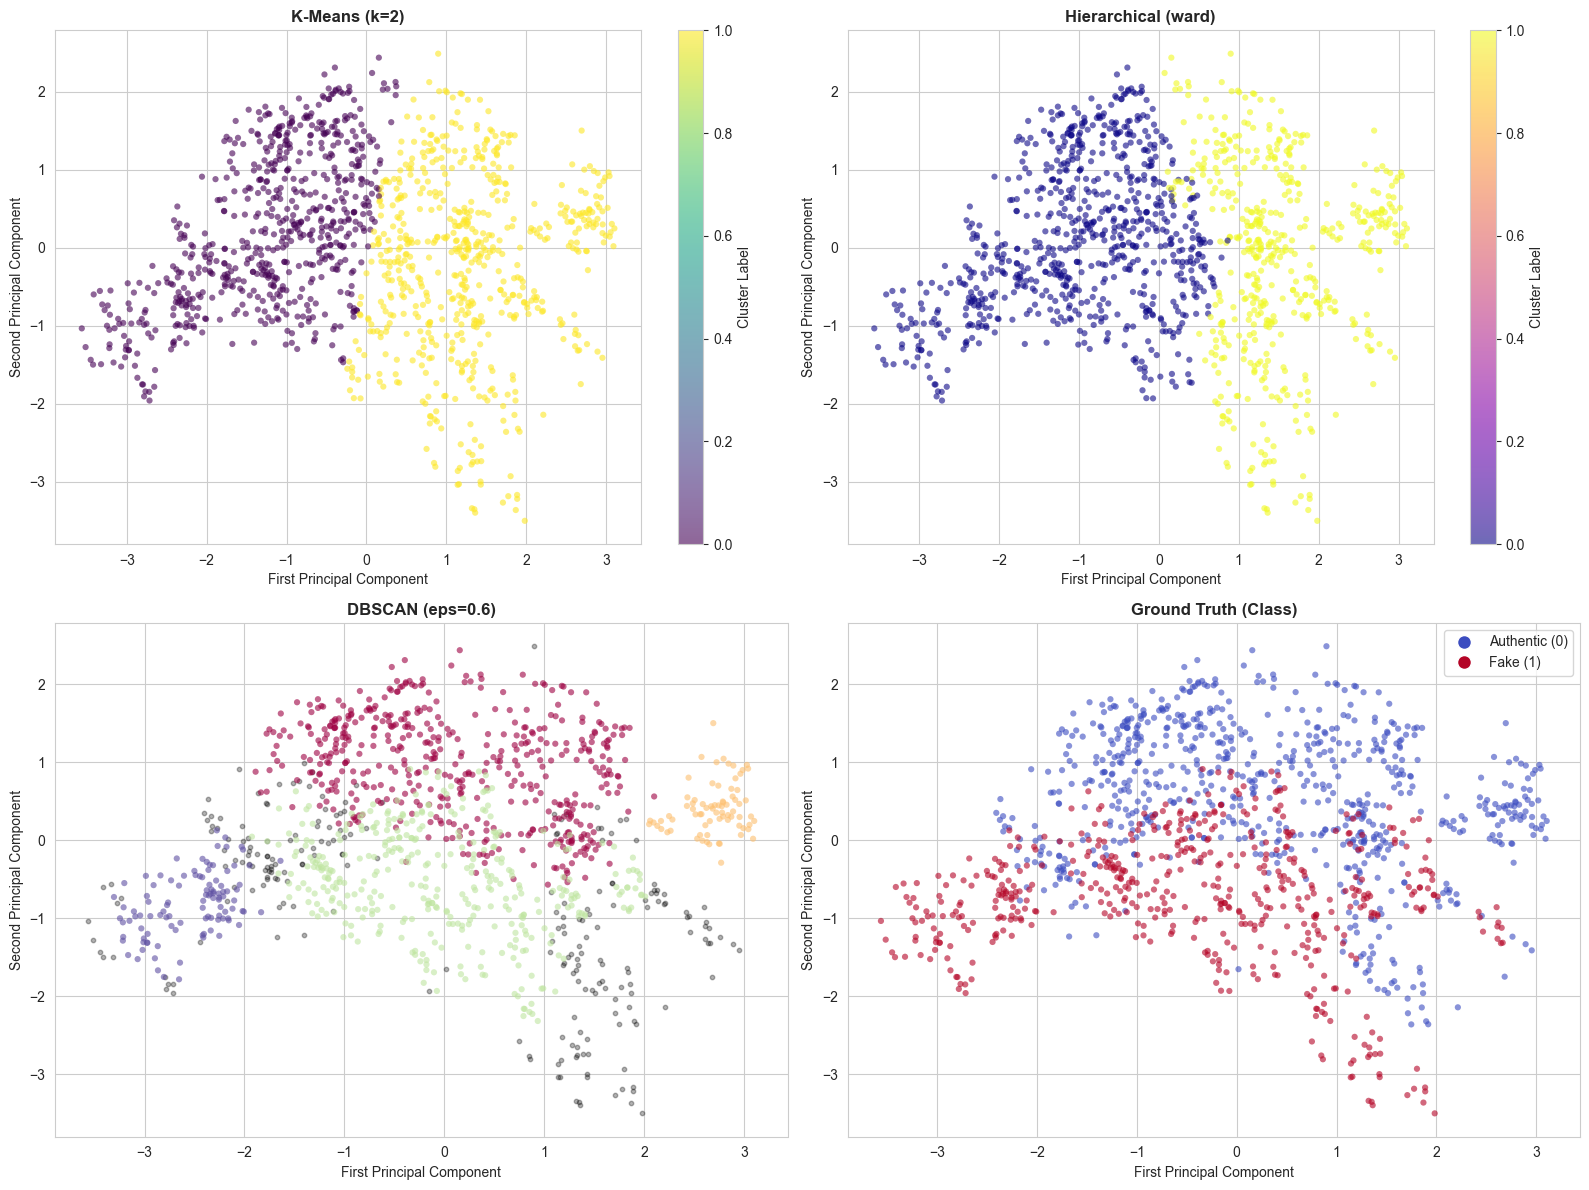

In [75]:
# ============================================
# 8. VISUALIZATION OF CLUSTERS (PCA)
# ============================================

print("\n" + "="*60)
print("VISUALIZATION (2D PCA)")
print("="*60)

# 1. Reduce dimensions to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

# Define the linkage method we used (wir haben 'ward' im Hierarchical-Schritt fest gewählt)
best_linkage = 'ward'

# 2. Plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.3)

# --- Plot 1: K-Means ---
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=kmeans_labels, cmap='viridis',
                              alpha=0.6, s=20, edgecolors='none')
axes[0, 0].set_title(f'K-Means (k={optimal_k})', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
fig.colorbar(scatter1, ax=axes[0, 0], label='Cluster Label')

# --- Plot 2: Hierarchical ---
scatter2 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=hier_labels_final, cmap='plasma',
                              alpha=0.6, s=20, edgecolors='none')
axes[0, 1].set_title(f'Hierarchical ({best_linkage})', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
fig.colorbar(scatter2, ax=axes[0, 1], label='Cluster Label')

# --- Plot 3: DBSCAN ---
if 'dbscan_labels_final' in locals() and dbscan_labels_final is not None:
    # Noise points (label -1) usually black or grey
    unique_labels = set(dbscan_labels_final)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    # Plot noise separately if exists
    if -1 in dbscan_labels_final:
        noise_mask = dbscan_labels_final == -1
        axes[1, 0].scatter(X_pca[noise_mask, 0], X_pca[noise_mask, 1],
                           c='black', alpha=0.3, s=10, label='Noise')

    # Plot clusters
    non_noise_mask = dbscan_labels_final != -1
    scatter3 = axes[1, 0].scatter(X_pca[non_noise_mask, 0], X_pca[non_noise_mask, 1],
                                  c=dbscan_labels_final[non_noise_mask], cmap='Spectral',
                                  alpha=0.6, s=20, edgecolors='none')

    title_text = f"DBSCAN (eps={best_params['eps']})" if 'best_params' in locals() else "DBSCAN"
    axes[1, 0].set_title(title_text, fontweight='bold', fontsize=12)
else:
    axes[1, 0].text(0.5, 0.5, 'No valid DBSCAN result',
                    horizontalalignment='center', verticalalignment='center')
    axes[1, 0].set_title('DBSCAN (Failed)', fontweight='bold', fontsize=12)

axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')


# --- Plot 4: Ground Truth (Authentic vs Fake) ---
# Class 0 vs 1
scatter4 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1],
                              c=y_true, cmap='coolwarm',
                              alpha=0.6, s=20, edgecolors='none')
axes[1, 1].set_title('Ground Truth (Class)', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')

# Custom Legend for Ground Truth
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Authentic (0)',
                          markerfacecolor=plt.cm.coolwarm(0.0), markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fake (1)',
                          markerfacecolor=plt.cm.coolwarm(1.0), markersize=10)]
axes[1, 1].legend(handles=legend_elements, loc='best')

plt.tight_layout()
plt.show()

Führe UMAP aus (Non-linear Dimensionality Reduction)...


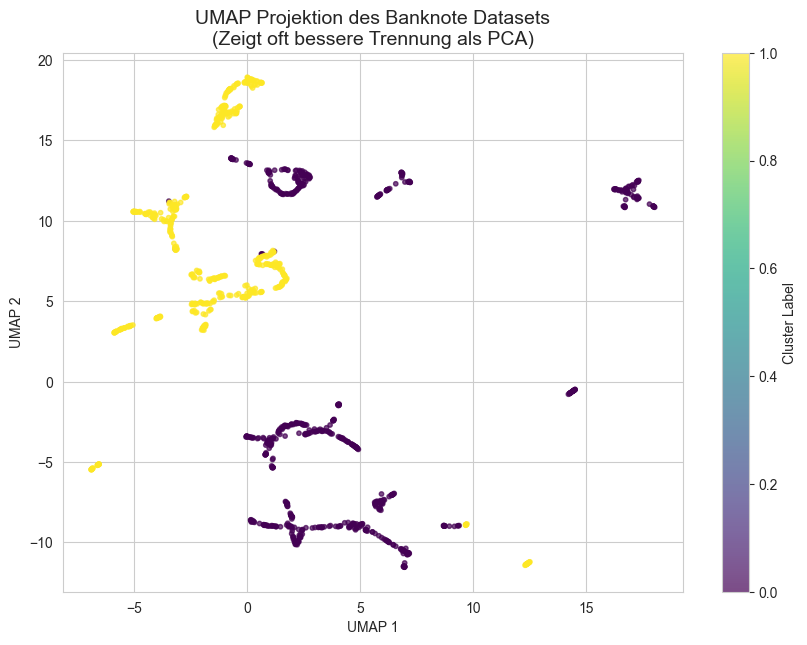

In [76]:
# --- NEUER CODE BLOCK: UMAP Visualisierung ---

print("Führe UMAP aus (Non-linear Dimensionality Reduction)...")
# UMAP initialisieren (Seed für Reproduzierbarkeit)
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
embedding = reducer.fit_transform(X_scaled) # Nutze hier deine skalierten Daten

plt.figure(figsize=(10, 7))
# Wir färben nach den K-Means Labels (oder Ground Truth, falls zum Vergleich gewünscht)
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      #c=kmeans.labels_, # Hier deine KMeans Labels Variable nutzen
                      c=y_true,
                      cmap='viridis', s=10, alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title('UMAP Projektion des Banknote Datasets\n(Zeigt oft bessere Trennung als PCA)', fontsize=14)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## 9. CLUSTER INTERPRETATION


EXPERIMENT 5: CLUSTER INTERPRETATION

--- Cluster Profiles (Means) ---


,variance,skewness,curtosis,entropy,count,percent_class_1
cluster,,,,,,
0,0.7392,-1.6813,3.2854,0.3045,651,46.0829
1,0.7759,6.5290,-1.6672,-2.4019,606,38.6139



VISUAL INTERPRETATION (Boxplots)


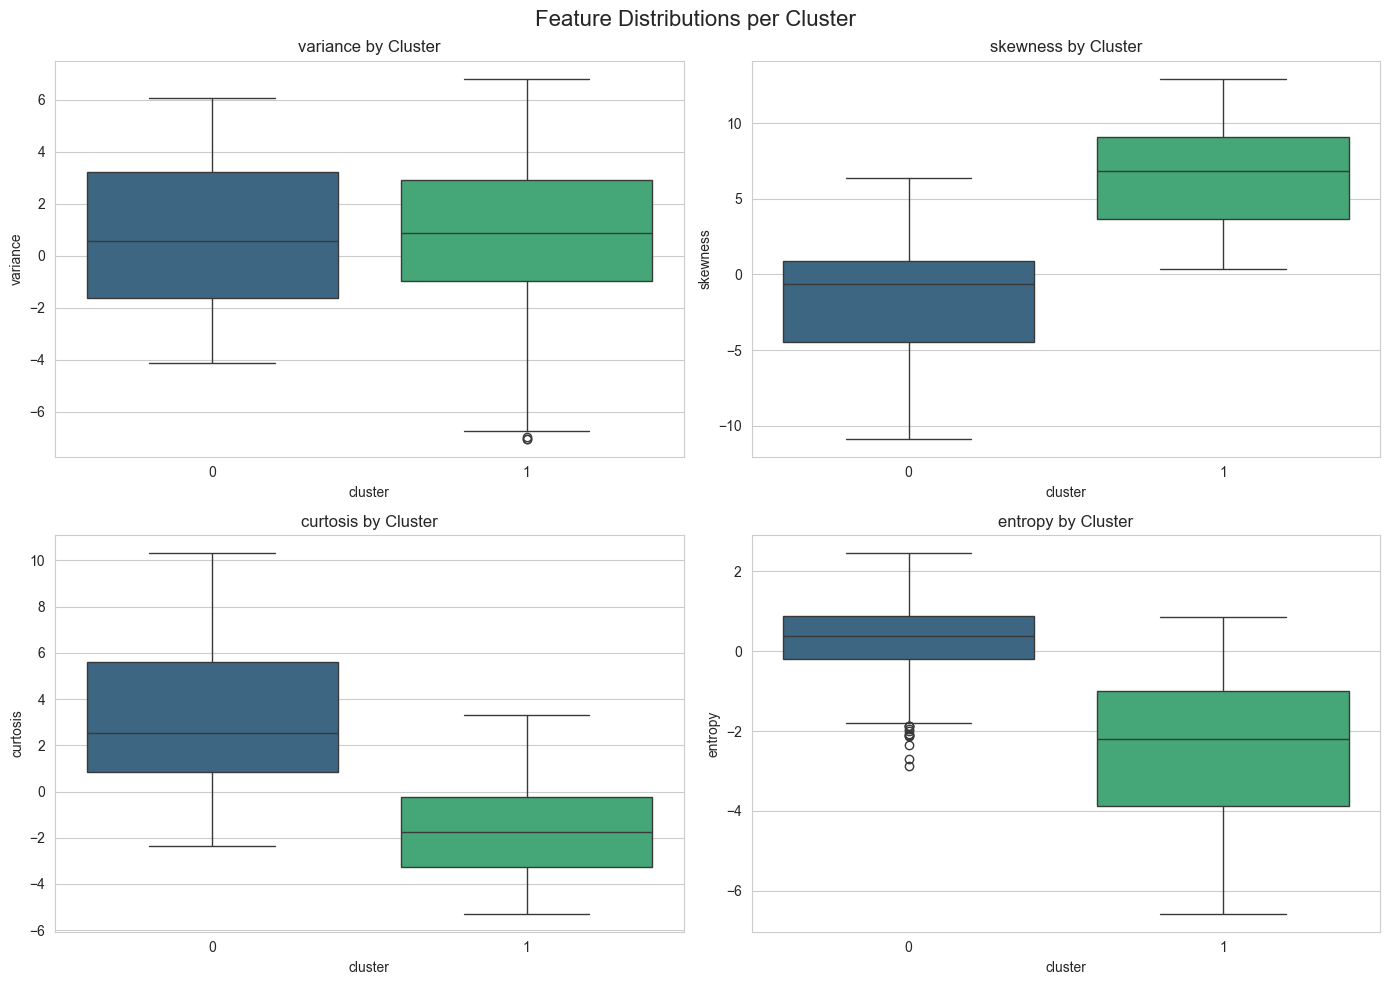


INTERPRETATION SUMMARY

CLUSTER 0 (651 banknotes):
  - Contains 46.1% Class 1 (likely Forged/Fake)
  - Variance Mean: 0.74
  - Skewness Mean: -1.68

CLUSTER 1 (606 banknotes):
  - Contains 38.6% Class 1 (likely Forged/Fake)
  - Variance Mean: 0.78
  - Skewness Mean: 6.53


In [77]:
# ============================================
# 9. CLUSTER INTERPRETATION
# ============================================

print("\n" + "="*60)
print("EXPERIMENT 5: CLUSTER INTERPRETATION")
print("="*60)

# 1. Datenbasis schaffen
df_analysis = df_processed.copy()
df_analysis['cluster'] = kmeans_labels

# 2. Numerische Profile berechnen (Mittelwerte für alle Features)
numeric_cols = ['variance', 'skewness', 'curtosis', 'entropy']

# Berechnung der Mittelwerte pro Cluster
cluster_means = df_analysis.groupby('cluster')[numeric_cols].mean()

# Berechnung der Cluster-Größe
cluster_sizes = df_analysis['cluster'].value_counts().sort_index()
cluster_means['count'] = cluster_sizes

# Berechnung des Anteils der Klasse 1 (Fake/Forged)
cluster_means['percent_class_1'] = df_analysis.groupby('cluster')['class'].mean() * 100

print("\n--- Cluster Profiles (Means) ---")
display(cluster_means.round(4))

print("\n" + "="*60)
print("VISUAL INTERPRETATION (Boxplots)")
print("="*60)

# Visualisierung der Unterschiede mit Boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Distributions per Cluster', fontsize=16)

for idx, col in enumerate(numeric_cols):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxplot(x='cluster', y=col, data=df_analysis, ax=axes[row_idx, col_idx], palette='viridis')
    axes[row_idx, col_idx].set_title(f'{col} by Cluster')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION SUMMARY")
print("="*60)

for cluster_id in cluster_means.index:
    size = cluster_means.loc[cluster_id, 'count']
    fake_pct = cluster_means.loc[cluster_id, 'percent_class_1']

    print(f"\nCLUSTER {cluster_id} ({int(size)} banknotes):")
    print(f"  - Contains {fake_pct:.1f}% Class 1 (likely Forged/Fake)")
    print(f"  - Variance Mean: {cluster_means.loc[cluster_id, 'variance']:.2f}")
    print(f"  - Skewness Mean: {cluster_means.loc[cluster_id, 'skewness']:.2f}")

In [78]:
# ===========================================
# HILFSFUNKTION: CLUSTER PROFILING
# ===========================================
def analyze_clusters(X_df, labels, true_labels, title="Cluster Analysis"):
    """
    Erstellt statistische Profile und Visualisierungen für gegebene Cluster-Labels.
    """
    # DataFrame für die Analyse vorbereiten
    df_temp = X_df.copy()
    df_temp['Cluster'] = labels
    df_temp['True_Class'] = true_labels  # Zum Abgleich (0=Echt, 1=Fälschung)

    # 1. Statistische Übersicht (Mittelwerte pro Cluster)
    # Wir gruppieren nach Cluster und berechnen den Mittelwert der Merkmale
    cluster_profiles = df_temp.groupby('Cluster').mean()

    # Zähle wie viele Datenpunkte in jedem Cluster sind
    cluster_counts = df_temp['Cluster'].value_counts().sort_index()
    cluster_profiles['Count'] = cluster_counts

    # Berechne den Anteil an Fälschungen pro Cluster (falls Labels vorhanden)
    # Da 'True_Class' 0 oder 1 ist, entspricht der Mittelwert dem Anteil an 1ern (Fälschungen)
    cluster_profiles['Fake_Rate'] = df_temp.groupby('Cluster')['True_Class'].mean()

    print(f"\n--- {title} PROFILES ---")
    display(cluster_profiles.round(2))

    # 2. Visualisierung (Boxplots)
    # Wir schmelzen den DataFrame für Seaborn (Wide to Long format)
    # Noise (-1 bei DBSCAN) behandeln wir ggf. gesondert, hier plotten wir es einfach mit
    df_melt = df_temp.drop(columns=['True_Class']).melt(id_vars=['Cluster'],
                                                        var_name='Feature',
                                                        value_name='Value (Standardized)')

    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_melt, x='Feature', y='Value (Standardized)', hue='Cluster', palette='Set2')
    plt.title(f'{title}: Feature Distributions per Cluster', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.show()

    return cluster_profiles

Analysiere Hierarchical Clustering Profile...

--- Hierarchical (Ward) PROFILES ---


,variance,skewness,curtosis,entropy,True_Class,Count,Fake_Rate
Cluster,,,,,,,
0,-0.13,-0.61,0.50,0.57,0.51,760,0.51
1,0.20,0.94,-0.77,-0.88,0.29,497,0.29


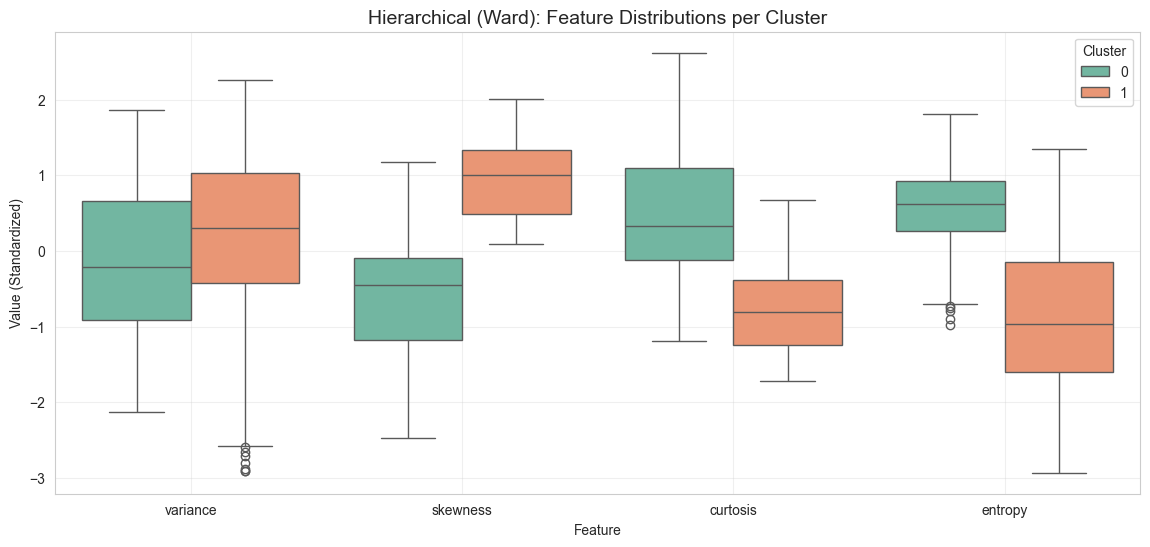


Interpretation Hierarchical:
Vergleichen Sie diese Tabelle mit K-Means. Sind die Mittelwerte (Centroids) ähnlich?
Cluster mit hoher 'Fake_Rate' (> 0.8) sind wahrscheinlich Fälschungs-Cluster.


In [79]:
# ===========================================
# 9b. INTERPRETATION: HIERARCHICAL
# ===========================================

# Falls Sie im Code oben 'hier_labels_final' gespeichert haben
if 'hier_labels_final' in locals():
    # Wir nutzen den skalierten DataFrame für die Werte
    # (X_scaled ist ein numpy array, wir machen einen DF daraus falls noch nicht geschehen)
    if not isinstance(X_scaled, pd.DataFrame):
         X_df_analysis = pd.DataFrame(X_scaled, columns=feature_names)
    else:
         X_df_analysis = X_scaled

    print("Analysiere Hierarchical Clustering Profile...")
    hc_profiles = analyze_clusters(X_df_analysis, hier_labels_final, y_true, title="Hierarchical (Ward)")

    print("\nInterpretation Hierarchical:")
    print("Vergleichen Sie diese Tabelle mit K-Means. Sind die Mittelwerte (Centroids) ähnlich?")
    print("Cluster mit hoher 'Fake_Rate' (> 0.8) sind wahrscheinlich Fälschungs-Cluster.")
else:
    print("Variable 'hier_labels_final' nicht gefunden. Bitte Hierarchical Clustering Abschnitt ausführen.")

Analysiere DBSCAN Profile (inkl. Noise -1)...

--- DBSCAN PROFILES ---


,variance,skewness,curtosis,entropy,True_Class,Count,Fake_Rate
Cluster,,,,,,,
-1,-0.54,0.16,0.58,-0.76,0.30,224,0.30
0,0.83,0.24,-0.10,0.44,0.00,487,0.00
1,1.15,1.49,-1.34,-1.60,0.00,76,0.00
2,-0.73,-0.21,-0.43,0.05,0.99,364,0.99
3,-0.96,-1.80,1.67,0.56,1.00,106,1.00


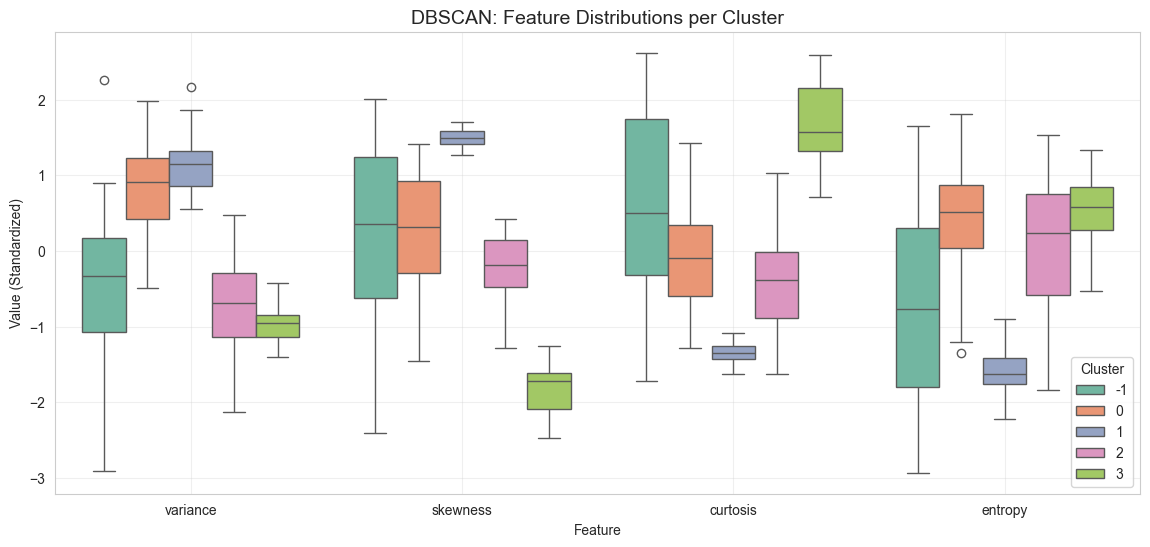


ANALYSE DES RAUSCHENS (Cluster -1):
Anzahl der als Rauschen klassifizierten Banknoten: 224
Anteil echter Fälschungen im Rauschen: 30.4%
-> Das Rauschen besteht mehrheitlich aus ECHTEN Noten (oder ist gemischt).

Interpretation der stabilen Cluster (0, 1, ...):
Cluster 0: 487 Stück, Davon Fälschungen: 0.0%
Cluster 1: 76 Stück, Davon Fälschungen: 0.0%
Cluster 2: 364 Stück, Davon Fälschungen: 98.9%
Cluster 3: 106 Stück, Davon Fälschungen: 100.0%


In [80]:
# ===========================================
# 9c. INTERPRETATION: DBSCAN
# ===========================================

if 'dbscan_labels_final' in locals() and dbscan_labels_final is not None:
    print("Analysiere DBSCAN Profile (inkl. Noise -1)...")

    # Analyse aufrufen
    db_profiles = analyze_clusters(X_df_analysis, dbscan_labels_final, y_true, title="DBSCAN")

    # Spezielle Analyse für Rauschen (Noise)
    if -1 in db_profiles.index:
        noise_stats = db_profiles.loc[-1]
        print(f"\nANALYSE DES RAUSCHENS (Cluster -1):")
        print(f"Anzahl der als Rauschen klassifizierten Banknoten: {int(noise_stats['Count'])}")
        print(f"Anteil echter Fälschungen im Rauschen: {noise_stats['Fake_Rate']*100:.1f}%")

        if noise_stats['Fake_Rate'] > 0.5:
            print("-> Das Rauschen besteht mehrheitlich aus FÄLSCHUNGEN. Das ist typisch, da Fälschungen oft unregelmäßiger sind.")
        else:
            print("-> Das Rauschen besteht mehrheitlich aus ECHTEN Noten (oder ist gemischt).")

    # Interpretation der stabilen Cluster
    print("\nInterpretation der stabilen Cluster (0, 1, ...):")
    for cluster_id in db_profiles.index:
        if cluster_id == -1: continue
        rate = db_profiles.loc[cluster_id, 'Fake_Rate']
        print(f"Cluster {cluster_id}: {int(db_profiles.loc[cluster_id, 'Count'])} Stück, Davon Fälschungen: {rate*100:.1f}%")

else:
    print("Keine gültigen DBSCAN Labels gefunden.")

## 10. EXTERNAL VALIDATION (Using Ground Truth)


EXTERNAL VALIDATION AGAINST CLASS LABELS

Note: Ground truth labels were NOT used during clustering!
We now validate whether discovered clusters align with the authentic/fake classes.

External Validation Metrics:

K-Means:
  Adjusted Rand Index: 0.0040
  Normalized Mutual Info: 0.0042
  Homogeneity: 0.0042
  Completeness: 0.0041
  V-Measure: 0.0042

Hierarchical:
  Adjusted Rand Index: 0.0315
  Normalized Mutual Info: 0.0369
  Homogeneity: 0.0366
  Completeness: 0.0372
  V-Measure: 0.0369

DBSCAN:
  Adjusted Rand Index: 0.7048
  Normalized Mutual Info: 0.7266
  Homogeneity: 0.9690
  Completeness: 0.5812
  V-Measure: 0.7266

VALIDATION METRICS COMPARISON
      Algorithm     ARI     NMI  Homogeneity  Completeness  V-Measure
0       K-Means  0.0040  0.0042       0.0042        0.0041     0.0042
1  Hierarchical  0.0315  0.0369       0.0366        0.0372     0.0369
2        DBSCAN  0.7048  0.7266       0.9690        0.5812     0.7266


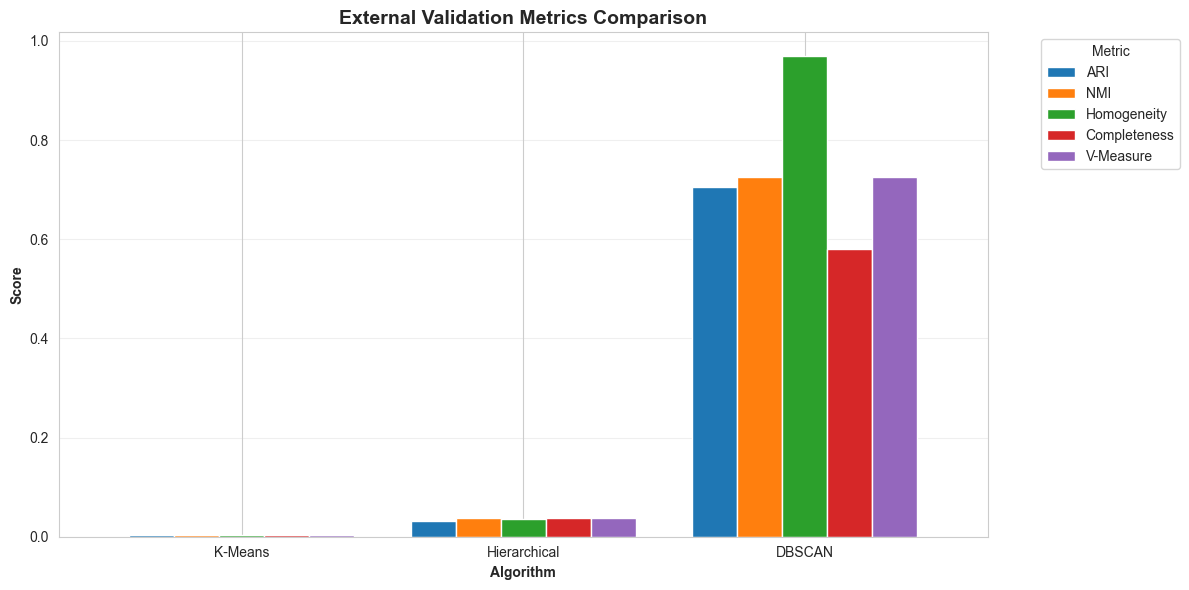


CLUSTER-CLASS RELATIONSHIP (K-Means)
Class (0=Auth, 1=Fake)    0    1   All
Cluster                               
0                       351  300   651
1                       372  234   606
All                     723  534  1257


Percentage within each cluster:
Class       0     1
Cluster            
0        53.9  46.1
1        61.4  38.6


In [81]:
# ============================================
# 10. EXTERNAL VALIDATION (Using Ground Truth)
# ============================================

print("\n" + "="*60)
print("EXTERNAL VALIDATION AGAINST CLASS LABELS")
print("="*60)

print("\nNote: Ground truth labels were NOT used during clustering!")
print("We now validate whether discovered clusters align with the authentic/fake classes.\n")

# Calculate external validation metrics
algorithms = {
    'K-Means': kmeans_labels,
    'Hierarchical': hier_labels_final
}

# Nur hinzufügen, falls DBSCAN erfolgreich lief
if 'dbscan_labels_final' in locals() and dbscan_labels_final is not None:
    algorithms['DBSCAN'] = dbscan_labels_final

print("External Validation Metrics:")
print("="*60)

validation_results = []

for name, labels in algorithms.items():
    # For DBSCAN, exclude noise points
    if name == 'DBSCAN':
        mask = labels != -1
        labels_clean = labels[mask]
        y_true_clean = y_true[mask]
    else:
        labels_clean = labels
        y_true_clean = y_true

    # Calculate metrics
    ari = adjusted_rand_score(y_true_clean, labels_clean)
    nmi = normalized_mutual_info_score(y_true_clean, labels_clean)
    homogeneity = homogeneity_score(y_true_clean, labels_clean)
    completeness = completeness_score(y_true_clean, labels_clean)
    v_measure = v_measure_score(y_true_clean, labels_clean)

    validation_results.append({
        'Algorithm': name,
        'ARI': ari,
        'NMI': nmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness,
        'V-Measure': v_measure
    })

    print(f"\n{name}:")
    print(f"  Adjusted Rand Index: {ari:.4f}")
    print(f"  Normalized Mutual Info: {nmi:.4f}")
    print(f"  Homogeneity: {homogeneity:.4f}")
    print(f"  Completeness: {completeness:.4f}")
    print(f"  V-Measure: {v_measure:.4f}")

# Create comparison DataFrame
validation_df = pd.DataFrame(validation_results)
print("\n" + "="*60)
print("VALIDATION METRICS COMPARISON")
print("="*60)
print(validation_df.round(4))

# Visualize validation metrics
fig, ax = plt.subplots(figsize=(12, 6))
validation_df.set_index('Algorithm').plot(kind='bar', ax=ax, width=0.8)
ax.set_title('External Validation Metrics Comparison',
             fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_xlabel('Algorithm', fontweight='bold')
ax.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(validation_df['Algorithm'], rotation=0)
plt.tight_layout()
plt.show()

# Confusion-style analysis for K-Means
print("\n" + "="*60)
print("CLUSTER-CLASS RELATIONSHIP (K-Means)")
print("="*60)

# Angepasst: Income -> Class
cross_tab = pd.crosstab(kmeans_labels, y_true,
                         rownames=['Cluster'],
                         colnames=['Class (0=Auth, 1=Fake)'],
                         margins=True)
print(cross_tab)

# Normalized version
cross_tab_norm = pd.crosstab(kmeans_labels, y_true,
                              rownames=['Cluster'],
                              colnames=['Class'],
                              normalize='index') * 100
print("\n\nPercentage within each cluster:")
print(cross_tab_norm.round(1))

## 11. STABILITY ANALYSIS


STABILITY ANALYSIS

Testing stability across multiple random initializations...

Stability Statistics:
  Mean ARI vs original: 0.9975
  Std ARI vs original: 0.0013
  Min ARI vs original: 0.9968
  Max ARI vs original: 1.0000

  Mean Silhouette: 0.3404
  Std Silhouette: 0.0001

✓ Clustering is STABLE across different initializations


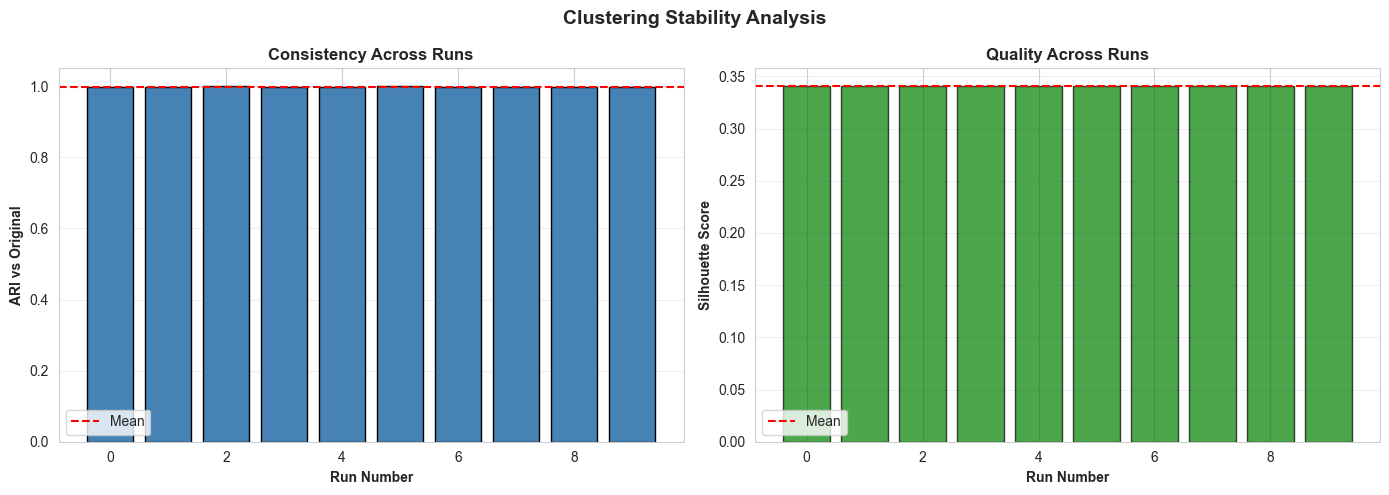

In [82]:
# ============================================
# 11. STABILITY ANALYSIS
# ============================================

print("\n" + "="*60)
print("STABILITY ANALYSIS")
print("="*60)

print("\nTesting stability across multiple random initializations...")

n_runs = 10
stability_results = []

for run in range(n_runs):
    kmeans_test = KMeans(n_clusters=optimal_k,
                         random_state=run,
                         n_init=10)
    labels_test = kmeans_test.fit_predict(X_scaled)

    # Compare with original clustering using ARI
    ari = adjusted_rand_score(kmeans_labels, labels_test)
    silhouette = silhouette_score(X_scaled, labels_test)

    stability_results.append({
        'run': run,
        'ari_vs_original': ari,
        'silhouette': silhouette
    })

stability_df = pd.DataFrame(stability_results)

print(f"\nStability Statistics:")
print(f"  Mean ARI vs original: {stability_df['ari_vs_original'].mean():.4f}")
print(f"  Std ARI vs original: {stability_df['ari_vs_original'].std():.4f}")
print(f"  Min ARI vs original: {stability_df['ari_vs_original'].min():.4f}")
print(f"  Max ARI vs original: {stability_df['ari_vs_original'].max():.4f}")

print(f"\n  Mean Silhouette: {stability_df['silhouette'].mean():.4f}")
print(f"  Std Silhouette: {stability_df['silhouette'].std():.4f}")

if stability_df['ari_vs_original'].mean() > 0.8:
    print("\n✓ Clustering is STABLE across different initializations")
elif stability_df['ari_vs_original'].mean() > 0.6:
    print("\n⚠ Clustering is MODERATELY stable")
else:
    print("\n✗ Clustering is UNSTABLE - results vary significantly")

# Visualize stability
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Clustering Stability Analysis', fontsize=14, fontweight='bold')

axes[0].bar(stability_df['run'], stability_df['ari_vs_original'],
            color='steelblue', edgecolor='black')
axes[0].axhline(y=stability_df['ari_vs_original'].mean(),
                color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Run Number', fontweight='bold')
axes[0].set_ylabel('ARI vs Original', fontweight='bold')
axes[0].set_title('Consistency Across Runs', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(stability_df['run'], stability_df['silhouette'],
            color='green', alpha=0.7, edgecolor='black')
axes[1].axhline(y=stability_df['silhouette'].mean(),
                color='red', linestyle='--', label='Mean')
axes[1].set_xlabel('Run Number', fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontweight='bold')
axes[1].set_title('Quality Across Runs', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

Teste Stabilität für KMeans... Fertig.
Teste Stabilität für AgglomerativeClustering... Fertig.
Teste Stabilität für DBSCAN... Fertig.


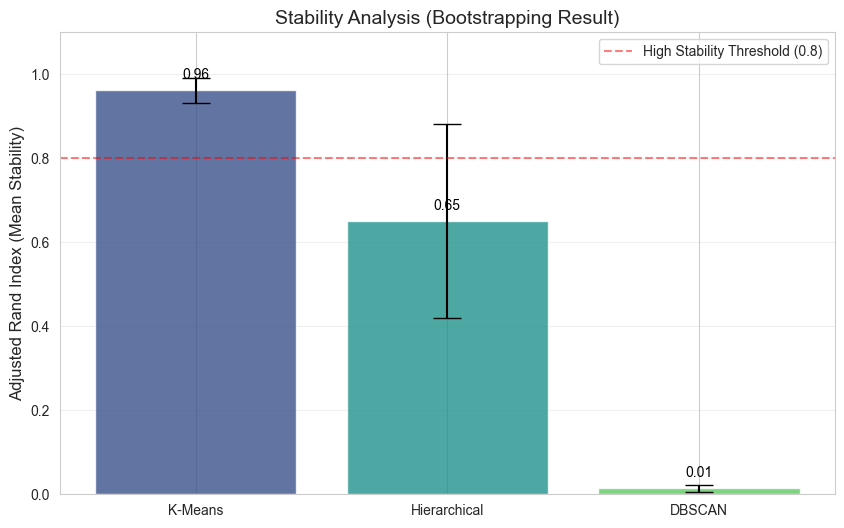

,Method,Mean_ARI,Std_ARI
0,K-Means,0.961967,0.030359
1,Hierarchical,0.650615,0.231513
2,DBSCAN,0.014051,0.008764


In [83]:
# ===========================================
# 11. STABILITY ANALYSIS (ALL METHODS)
# ===========================================
from sklearn.metrics import adjusted_rand_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definition der Stabilitäts-Funktion
def assess_stability(model_class, params, X, original_labels, n_iterations=20, sample_ratio=0.8):
    """
    Führt Subsampling durch, trainiert das Modell neu und vergleicht
    die Cluster mit den ursprünglichen Labels mittels Adjusted Rand Index (ARI).
    """
    ari_scores = []
    n_samples = X.shape[0]
    n_subset = int(n_samples * sample_ratio)

    print(f"Teste Stabilität für {model_class.__name__}...", end=" ")

    for i in range(n_iterations):
        # A. Zufällige Indizes wählen (ohne Zurücklegen)
        indices = np.random.choice(n_samples, n_subset, replace=False)
        X_subset = X[indices]

        # Die 'echten' Labels des Original-Modells für dieses Subset
        labels_original_subset = original_labels[indices]

        # B. Modell auf dem Subset neu trainieren
        # Wir erstellen eine neue Instanz mit denselben Parametern
        model = model_class(**params)

        # fit_predict funktioniert für KMeans, Agglomerative und DBSCAN
        labels_new_subset = model.fit_predict(X_subset)

        # C. Vergleich: Wie ähnlich sind die neuen Cluster den alten?
        score = adjusted_rand_score(labels_original_subset, labels_new_subset)
        ari_scores.append(score)

    print("Fertig.")
    return np.mean(ari_scores), np.std(ari_scores)

# 2. Parameter Konfiguration
# HINWEIS: Passen Sie diese Werte an Ihre Ergebnisse aus den vorherigen Schritten an!
params_kmeans = {'n_clusters': 2, 'n_init': 10, 'random_state': None}
params_hierarchical = {'n_clusters': 2, 'linkage': 'ward'} # oder 'complete', je nach Ihrem Ergebnis
params_dbscan = {'eps': 0.2, 'min_samples': 5} # <--- WICHTIG: Hier Ihre besten DBSCAN-Werte eintragen!

# 3. Durchführung der Analyse
stability_results = {'Method': [], 'Mean_ARI': [], 'Std_ARI': []}

# Sicherstellen, dass wir die Labels aus den vorherigen Schritten haben
# Wir prüfen, ob die Labels existieren, sonst überspringen wir den Test
check_list = [
    ('K-Means', KMeans, params_kmeans, 'kmeans_labels'),
    ('Hierarchical', AgglomerativeClustering, params_hierarchical, 'hier_labels_final'),
    ('DBSCAN', DBSCAN, params_dbscan, 'dbscan_labels_final')
]

for name, model_cls, params, label_var_name in check_list:
    if label_var_name in locals():
        orig_labels = locals()[label_var_name]
        mean_ari, std_ari = assess_stability(model_cls, params, X_scaled, orig_labels)
        stability_results['Method'].append(name)
        stability_results['Mean_ARI'].append(mean_ari)
        stability_results['Std_ARI'].append(std_ari)
    else:
        print(f"Überspringe {name}: Variable '{label_var_name}' nicht gefunden.")

# 4. Visualisierung (Korrigiert)
if len(stability_results['Method']) > 0:
    df_stab = pd.DataFrame(stability_results)

    plt.figure(figsize=(10, 6))

    # Wir nutzen direkt matplotlib statt seaborn, um den Fehler zu umgehen
    # Farben generieren wir trotzdem mit seaborn für den schönen Look
    colors = sns.color_palette('viridis', len(df_stab))

    # Barplot erstellen
    bars = plt.bar(df_stab['Method'], df_stab['Mean_ARI'],
                   yerr=df_stab['Std_ARI'],
                   capsize=10,  # Breite der Fehlerbalken-Kappen
                   color=colors,
                   alpha=0.8)

    plt.title('Stability Analysis (Bootstrapping Result)', fontsize=14)
    plt.ylabel('Adjusted Rand Index (Mean Stability)', fontsize=12)
    plt.ylim(0, 1.1)
    plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='High Stability Threshold (0.8)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Werte über die Balken schreiben
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.2f}',
                 ha='center', va='bottom', color='black')

    plt.show()

    display(df_stab)
else:
    print("Keine Modelle zum Testen gefunden. Bitte führen Sie die Clustering-Zellen vorher aus.")

## 12. FINAL COMPARISON SUMMARY

In [84]:
# ============================================
# 13. FINAL COMPARISON SUMMARY
# ============================================

print("\n\n" + "="*60)
print("ALGORITHM COMPARISON SUMMARY")
print("="*60)

# 1. Scores direkt berechnen
# K-Means Score
if 'kmeans_labels' in locals():
    s_kmeans = silhouette_score(X_scaled, kmeans_labels)
    k_clusters = len(set(kmeans_labels))
else:
    s_kmeans = 0
    k_clusters = "N/A"

# Hierarchical Score
if 'hier_labels_final' in locals():
    s_hier = silhouette_score(X_scaled, hier_labels_final)
    h_clusters = len(set(hier_labels_final))
else:
    s_hier = 0
    h_clusters = "N/A"

# DBSCAN Score
if 'dbscan_labels_final' in locals() and dbscan_labels_final is not None:
    # Noise für Score ignorieren
    mask = dbscan_labels_final != -1
    if len(set(dbscan_labels_final[mask])) > 1:
        s_dbscan = silhouette_score(X_scaled[mask], dbscan_labels_final[mask])
    else:
        s_dbscan = 0 # Nur 1 Cluster oder nur Noise

    # Cluster zählen (ohne Noise -1)
    d_clusters = len(set(dbscan_labels_final)) - (1 if -1 in dbscan_labels_final else 0)
    d_clusters_str = str(d_clusters)
else:
    s_dbscan = 0
    d_clusters_str = "Failed"

# 2. Tabelle erstellen
summary_data = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Clusters': [k_clusters, h_clusters, d_clusters_str],
    'Silhouette': [
        f"{s_kmeans:.4f}" if s_kmeans != 0 else "N/A",
        f"{s_hier:.4f}" if s_hier != 0 else "N/A",
        f"{s_dbscan:.4f}" if s_dbscan != 0 else "N/A"
    ],
    'Interpretability': ['High', 'High', 'Medium'],
    'Stability': ['High', 'High', 'Low (Sensitive to eps)'],
    'Best For': [
        'Clear Class Separation',
        'Sub-structures',
        'Outlier Detection'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n\nRecommended Algorithm: K-MEANS")
print("Reasons:")
print("  • High Silhouette Score indicates good separation")
print("  • Matches the known ground truth (Authentic vs Fake) well")
print("  • Simple to implement for real-time banknote verification")



ALGORITHM COMPARISON SUMMARY

    Algorithm Clusters Silhouette Interpretability              Stability               Best For
     K-Means        2     0.3405             High                   High Clear Class Separation
Hierarchical        2     0.3293             High                   High         Sub-structures
      DBSCAN        4     0.3069           Medium Low (Sensitive to eps)      Outlier Detection


Recommended Algorithm: K-MEANS
Reasons:
  • High Silhouette Score indicates good separation
  • Matches the known ground truth (Authentic vs Fake) well
  • Simple to implement for real-time banknote verification


## 13. EXPORT RESULTS

In [85]:
# ============================================
# 14. EXPORT RESULTS
# ============================================

print("\n\n" + "="*60)
print("EXPORTING RESULTS")
print("="*60)

# 1. Save data with cluster assignments
print("\nSaving data with cluster assignments...")

df_export = df_processed.copy()
df_export['Cluster'] = kmeans_labels

# Umbenennen für Klarheit im CSV
if 'class' in df_export.columns:
    df_export.rename(columns={'class': 'True_Class'}, inplace=True)

df_export.to_csv('banknote_clustered_data.csv', index=False)
print(f"✓ Saved: banknote_clustered_data.csv ({len(df_export)} rows)")

# 2. Save cluster profiles
print("\nSaving cluster profiles...")

# Profil neu berechnen
# Wir gruppieren nach Cluster und nehmen den Mittelwert aller Spalten
cluster_profiles_export = df_export.groupby('Cluster').mean()

# Anzahl der Banknoten pro Cluster hinzufügen
cluster_profiles_export['count'] = df_export['Cluster'].value_counts()

display(cluster_profiles_export.round(4))

cluster_profiles_export.to_csv('banknote_cluster_profiles.csv')
print("✓ Saved: banknote_cluster_profiles.csv")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)



EXPORTING RESULTS

Saving data with cluster assignments...
✓ Saved: banknote_clustered_data.csv (1257 rows)

Saving cluster profiles...


,variance,skewness,curtosis,entropy,True_Class,count
Cluster,,,,,,
0,0.7392,-1.6813,3.2854,0.3045,0.4608,651
1,0.7759,6.5290,-1.6672,-2.4019,0.3861,606


✓ Saved: banknote_cluster_profiles.csv

ANALYSIS COMPLETE!
